In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyhf

In [2]:
np.random.seed(0)
plt.rcParams.update({"font.size": 14})

# Running Monte Carlo simulations (toys)

Finding the (expected) significance can involve costly Monte Carlo calculations ("toys"). The asymptotic approximation described in the paper by Cowan, Cranmer, Gross, Vitells: *Asymptotic formulae for likelihood-based tests of new physics* [[arXiv:1007.1727](https://arxiv.org/abs/1007.1727)] provides an alternative to these computationally expensive toy calculations.

This notebook demonstrates a reproduction of one of the key plots in the paper using `pyhf`.

![Figure 5 from arXiv:1007.1727 for background-only ($mu=0$) and background+signal ($mu=1$) are shown for two different test statistics, comparing the asymptotic and toy calculations.](img/1007.1727.fig5.png)

## Counting Experiment

Consider a counting experiment where one observes $n$ events, following a Poisson distribution with expectation value

$$
E[n] = \mu s + b 
$$

with $s$ expected signal events and $b$ expected background events, and signal strength parameter $\mu$. Follow up in the paper to understand more of the math behind this as the notation is being introduced here. What we will show is the distribution of the (alternative) test statistic $q_1$ ($\tilde{q}_1$) calculated under the assumption of the nominal signal model $(\mu=1)$ for data corresponding to the strength parameter of the background-only $(\mu' = 0)$ and signal+background $(\mu' = 1)$ model hypotheses. For the rest of this notebook, we'll refer to the background-like model $\mu'=0$ and the signal-like model $\mu'=1$.

The first thing we will do is set up the `pyhf` model with $s=6$ signal events and $b=9$ background events (adding a Poisson uncertainty on the background).

In [3]:
signal = 6
background = 9
background_uncertainty = 3
model = pyhf.simplemodels.hepdata_like([signal], [background], [background_uncertainty])
print(f"Channels: {model.config.channels}")
print(f"Samples: {model.config.samples}")
print(f"Parameters: {model.config.parameters}")

Channels: ['singlechannel']
Samples: ['background', 'signal']
Parameters: ['mu', 'uncorr_bkguncrt']


This is a single channel with two samples: `signal` and `background`. `mu` here is the signal strength. Next, we need to define the background-like and signal-like p.d.f.s.

In [4]:
# mu' = 0: background-like
pars_bkg = model.config.suggested_init()
pars_bkg[model.config.poi_index] = 0.0
print(f"Background parameters: {list(zip(model.config.parameters, pars_bkg))}")

# mu' = 1: signal-like
pars_sig = model.config.suggested_init()
pars_sig[model.config.poi_index] = 1.0
print(f"Signal parameters: {list(zip(model.config.parameters, pars_sig))}")

# make the pdfs
pdf_bkg = model.make_pdf(pyhf.tensorlib.astensor(pars_bkg))
pdf_sig = model.make_pdf(pyhf.tensorlib.astensor(pars_sig))

Background parameters: [('mu', 0.0), ('uncorr_bkguncrt', 1.0)]
Signal parameters: [('mu', 1.0), ('uncorr_bkguncrt', 1.0)]


Notice that the parameter of interest, $\mu'$ is set to zero for background-like models and to one for signal-like models.

### Running Toys by Hand

Now that we've built our pdfs, we can go ahead and randomly (Monte Carlo) sample them. In this case, we want to "run 2,000 pseudo-experiments" (or "throw toys" as particle physicists would say). This means to draw $n=2000$ samples from the models:

In [5]:
# note: pdf.sample takes in a "shape" N=(2000,) given the number of samples
n_samples = 2000

# mu' = 0
mc_bkg = pdf_bkg.sample((n_samples,))
# mu' = 1
mc_sig = pdf_sig.sample((n_samples,))

print(mc_bkg.shape)
print(mc_sig.shape)

(2000, 2)
(2000, 2)


You'll notice that the shape for `mc_bkg` and `mc_sig` is not the input shape we passed in `(2000,)` but rather `(2000,2)`! Why is that? The HistFactory model is a product of many separate pdfs: Poissons representing the main model, and Gaussians representing the auxiliary measurements. In `pyhf`, this is represented under the hood as a [`Simultaneous`](https://scikit-hep.org/pyhf/_generated/pyhf.probability.Simultaneous.html) pdf of the main model and the auxiliary model &mdash; hence the second dimension.

We can now calculate the test statistic distributions for $\tilde{q}_1$ given the background-like and signal-like models. This inference step (running the toys) will take some time:

In [6]:
qtilde_bkg = pyhf.tensorlib.astensor(
    [pyhf.infer.qmu(1.0, mc, model, None, None) for mc in mc_bkg]
)
qtilde_sig = pyhf.tensorlib.astensor(
    [pyhf.infer.qmu(1.0, mc, model, None, None) for mc in mc_sig]
)

### Running Toys using Calculators

However, as you can see, a lot of this is somewhat cumbersome as you need to carry around two pieces of information: one for background-like and one for signal-like. Instead, `pyhf` provides a statistics calculator API that both simplifies and harmonizes some of this work for you.

This calculator API allows you to:

- compute a test statistic for the observed data
- provide distributions of that test statistic under various hypotheses

These provided distributions additionally have extra functionality to compute a *p*-value for the observed test statistic.

We will create a toy-based calculator and evaluate the model $(\mu=1)$ for data simulated under background-like hypothesis $(\mu'=0)$ and under the signal-like hypothesis $(\mu'=1)$. This will compute $\tilde{q}_1$ for both values of $\mu'$.

In [7]:
toy_calculator_qtilde = pyhf.infer.utils.create_calculator(
    "toybased", model.expected_data(pars_sig), model, ntoys=n_samples
)
qtilde_sig, qtilde_bkg = toy_calculator_qtilde.distributions(1.0)

To compute $q_1$, we just need to alleviate the bounds to allow for $\mu$ (the parameter of interest) to go below zero. Right now, it is set to the default for `normfactor` which is `[0,10]` &mdash; a very sensible default most of the time. But if the $\hat{\mu}$ (the maximum likelihood estimator for $\mu$) for our model is truly negative, then we should allow the fit to scan negative $\mu$ values as well.

In [8]:
bounds = model.config.suggested_bounds()
print(f"Old bounds: {bounds}")
bounds[model.config.poi_index] = (-10, 10)
print(f"New bounds: {bounds}")

Old bounds: [(0, 10), (1e-10, 10.0)]
New bounds: [(-10, 10), (1e-10, 10.0)]


And then run the toys

In [9]:
toy_calculator_qmu = pyhf.infer.utils.create_calculator(
    "toybased",
    model.expected_data(model.config.suggested_init()),
    model,
    par_bounds=bounds,
    ntoys=n_samples,
)
qmu_sig, qmu_bkg = toy_calculator_qmu.distributions(1.0)

Signal-like:   0%|          | 0/2000 [00:00<?, ?toy/s]/Users/kratsg/pyhf/src/pyhf/tensor/numpy_backend.py:253: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)


Now that we've ran the toys, we can make the key plots 🙂.

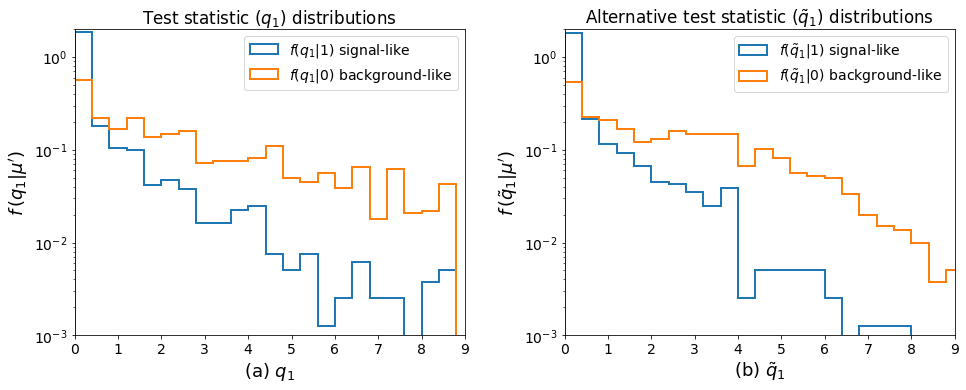

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2)
for ax in axes:
    ax.set_xticks(np.arange(0, 10))
ax0, ax1 = axes.flatten()

bins = np.linspace(0, 10, 26)

ax0.hist(
    qmu_sig.samples,
    bins=bins,
    histtype="step",
    density=True,
    label="$f(q_1|1)$ signal-like",
    linewidth=2,
)
ax0.hist(
    qmu_bkg.samples,
    bins=bins,
    histtype="step",
    density=True,
    label="$f(q_1|0)$ background-like",
    linewidth=2,
)
ax0.set_xlabel(r"(a) $q_1$", fontsize=18)
ax0.set_ylabel(r"$f\,(q_1|\mu')$", fontsize=18)
ax0.set_title(r"Test statistic $(q_1)$ distributions")
ax0.legend()

ax1.hist(
    qtilde_sig.samples,
    bins=bins,
    histtype="step",
    density=True,
    label=r"$f(\tilde{q}_1|1)$ signal-like",
    linewidth=2,
)
ax1.hist(
    qtilde_bkg.samples,
    bins=bins,
    histtype="step",
    density=True,
    label=r"$f(\tilde{q}_1|0)$ background-like",
    linewidth=2,
)
ax1.set_xlabel(r"(b) $\tilde{q}_1$", fontsize=18)
ax1.set_ylabel(r"$f\,(\tilde{q}_1|\mu')$", fontsize=18)
ax1.set_title(r"Alternative test statistic $(\tilde{q}_1)$ distributions")
ax1.legend()


plt.setp(axes, xlim=(0, 9), ylim=(1e-3, 2), yscale="log")
fig.set_size_inches(14, 6)
fig.tight_layout(pad=2.0)